In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
# pylint: disable=no-member
"""
Created on Tue May 16 11:42:45 2017
@author: github.com/Quantmatic
"""
import datetime
import time
import pandas as pd
import TTR
import amipy
from amipy import Amipy

In [7]:
def _months(_df):
    months = _df.index.month
    return pd.Series(months, index=_df.index, name='months', dtype=int)

def _days(_df):
    days = _df.index.day
    return pd.Series(days, index=_df.index, name='days', dtype=int)

In [8]:
class BollingerCMF(object):
    ''' Bollinger CMF '''
    def __init__(self, context):
        self.__dict__.update(context.__dict__)

    def Run(self, data):
        ''' analyze OHLCV matrix and generate signals '''
        ohlc = data[:][['open', 'high', 'low', 'close', 'volume']]
        ptimer = time.time()

        bbperiod = 25
        bbupper, bblower, bbmid = TTR.bollinger(ohlc.close, bbperiod, 2)

        cmf_period = bbperiod*2
        cmf = TTR.cmf(ohlc, cmf_period)

        days = _days(ohlc)
        months = _months(ohlc)
        #*** no trading during Christmas season ***#
        notradetime = (months.shift(1) == 12) & (days.shift(1) > 23)

        buysignal1 = (cmf.shift(1) > 0) & \
                     (abs(ohlc.close.shift(1)-bblower.shift(1)) < 5*self.tick_size)
        buy = (buysignal1) & (notradetime == 0)

        shortsignal1 = (cmf.shift(1) < 0) & \
                       (abs(ohlc.close.shift(1)-bbupper.shift(1)) < 5*self.tick_size)
        short = (shortsignal1) & (notradetime == 0)

        short[:self.warmup_bars] = False #remove signals from warmup bars
        buy[:self.warmup_bars] = False   #remove signals from warmup bars

        stopcover = (ohlc.open.shift(1) > bbmid.shift(1)) & \
                    (ohlc.close.shift(1) < bbmid.shift(1))

        stopsell = (ohlc.open.shift(1) < bbmid.shift(1)) & \
                   (ohlc.close.shift(1) > bbmid.shift(1))

        cover = buy | stopcover
        sell = short | stopsell

        buy = amipy.ex_rem(buy, sell, 1) #remove excess signals
        short = amipy.ex_rem(short, cover, 1) #remove excess signals

        buyprice = ohlc.open + (2*self.tick_size) ## *adjust for slippage
        shortprice = ohlc.open - (2*self.tick_size) ## *adjust for slippage
        coverprice = ohlc.open + (1*self.tick_size)
        sellprice = ohlc.open - (1*self.tick_size)

        backtest = Amipy(self, ohlc)

        backtest.run(buy, short, sell, cover, buyprice,
                     shortprice, sellprice, coverprice)

        print 'Backtest finished in ' + str(time.time()-ptimer) + ' seconds.\n'
        backtest.analyze_results(0.0025)
        backtest.analyze_results_ffn(0.0025)
        backtest.annual_gains(2011, 2016)
        backtest.plot_trades(2011, 2016)
        

In [9]:
class Context(object):
    ''' backtest context '''
    def __init__(self):
        self.symbol = '@ES#4H'  #*** e-mini SP 240min continuous ***#
        self.dbase = 'FUTURE'
        self.starting_equity = 100000.00
        self.margin_required = 5500.0
        self.tick_size = 0.25
        self.tick_value = 12.5
        self.risk = 0.2
        self.warmup_bars = 500
        self.commission = 4.50

In [10]:
    START_DATE = datetime.datetime(2011, 1, 2)
    END_DATE = datetime.datetime(2016, 12, 31)

In [11]:
OBJ = Context()

In [12]:
OHLC = amipy.mongo_grab(OBJ.symbol, OBJ.dbase, START_DATE, END_DATE)

Symbol: @ES#4H
Collection retrived in 0.0807559490204 seconds. 9562 Bars.



In [13]:
STRAT = BollingerCMF(OBJ)

Backtest finished in 0.0561060905457 seconds.

Starting Equity: 100000.0
Final Equity: 238454.0
Profitable trades: 85
Losing trades: 32
Winrate: 72.65%
Short winrate: 62.16%
Long winrate: 77.5%
Sharpe: 3.12 
Sortino: 4.28 
CAGR: 15.60% 
Profit factor: 2.04
Consecutive losses: 2
Max drawdown: 11.38%


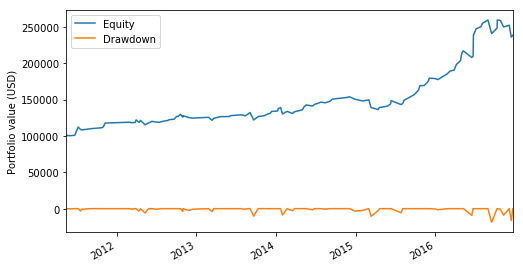

Stats for equity from 2011-05-15 00:00:00 - 2016-12-21 00:00:00
Annual risk-free rate considered: 0.25%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
138.45%             3.12  16.77%  -11.38%

Annualized Returns:
mtd     3m      6m      ytd     1y      3y      5y      10y     incep.
------  ------  ------  ------  ------  ------  ------  ------  --------
-4.51%  -0.89%  14.80%  33.32%  33.02%  21.53%  15.83%  16.77%  16.77%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  3.12     1.42       1.38
mean    107.92%  17.54%     15.60%
vol     34.52%   12.22%     11.15%
skew    0.76     -0.10      1.23
kurt    11.01    0.51       1.10
best    13.76%   9.92%      33.32%
worst   -7.77%   -7.22%     5.77%

Drawdowns:
max      avg       # days
-------  ------  --------
-11.38%  -4.13%     88.14

Misc:
---------------  -------
avg. up month    3.19%
avg. down month  -2.44%
up year %        100.00

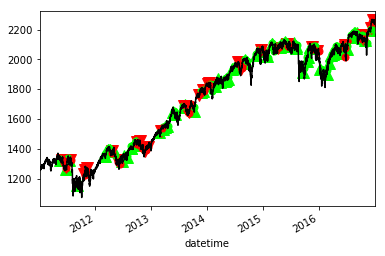

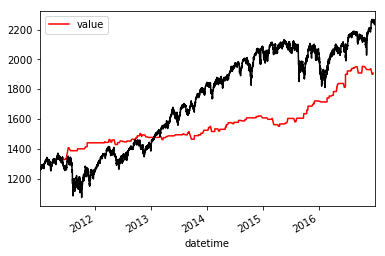

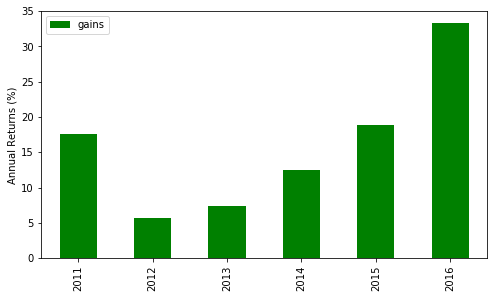

In [15]:
STRAT.Run(OHLC)